In [13]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import math
import einops
import numpy as np
from PIL import Image
import torchvision
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from utils import PlaneSet2Neurons, configurate_xy_tensors

from transformers import ViTFeatureExtractor, ViTForImageClassification
from IPython.display import display

torch.manual_seed(42)

##### Load model
---

Если обучаешь эту модель с нуля, то расскоменть все строчки в ячейке ниже и не выполняй ячейку с _Load model if necessary_. Если хочешь загрузить модель из пикля, то закомменть `model = ViTForImageClass` и не выполняй ячейку _Replace the latest feed-forward layer_

In [2]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

In [3]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print("Trainable parameters amount: {:n}".format(params))

Trainable parameters amount: 86 567 656


##### Replace the latest feed-forward layer
---

In [4]:
print(model.classifier)
model.classifier = nn.Linear(768, 2)
print(model.classifier)

Linear(in_features=768, out_features=1000, bias=True)
Linear(in_features=768, out_features=2, bias=True)


##### <span style="color:red">Load model if necessary</span>
---

In [ ]:
with open("fine_tuned_transformer_20epo", "rb") as bfile:
    model = pickle.load(bfile)

##### Fine tune the model
---

In [5]:
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 8
batch_size = 8
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device=device)

# data
# --------------------------
csv_path = r"../train"
images_path = r"../avia-train/"
with open(csv_path, "r") as file:
    data = pd.read_csv(file)
msk = np.random.rand(len(data)) < 0.8
train_df = data[msk]
test_df = data[~msk]
train_dataset = PlaneSet2Neurons(images_path, train_df)
test_dataset = PlaneSet2Neurons(images_path, test_df)
train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
def convert_batch_to_pil(batch):
    return [
        torchvision.transforms.ToPILImage()(i)
        for i in batch
    ]

In [7]:
def predict(model, test, batch_size=5):
    correct = 0
    batch_num = 0

    for x, y in iter(test):
        x, y = configurate_xy_tensors(x, y)
        x = convert_batch_to_pil(x)
        x = feature_extractor(images=x, return_tensors="pt")
        y = einops.rearrange(y, "b h w -> b (h w)")

        with torch.no_grad():
            y_hat = model(x.pixel_values.cuda())

        logits = y_hat.logits

        bool_res = np.array(list(map(
            lambda x: (x[0] & x[1]).cpu().numpy(), 
            torch.tensor(y.to(int) == torch.round(logits).to(int))
        ))).astype(float)

        correct += bool_res.sum()
        batch_num += 1

    return correct / (batch_num * batch_size)

In [8]:
%%time
loss_dict = {}
accuracy_dict = {}

print(f"Run on {num_epochs} epochs with batch_size={batch_size}\n~time: {round(num_epochs * (19*60+5) / 60, 3)}s")

for epoch in range(num_epochs):
    loss_train_accumulator = []

    for ind, (x, y) in enumerate(train):
        x, y = configurate_xy_tensors(x, y)
        x = convert_batch_to_pil(x)
        x = feature_extractor(images=x, return_tensors="pt")
        y_hat = model(x.pixel_values.cuda())
        logits = y_hat.logits
        optimizer.zero_grad()

        y = einops.rearrange(y, "b h w -> b (h w)")
        loss = distance(logits, y)
        diff = loss.item()

        loss.backward()
        optimizer.step()
        loss_train_accumulator.append(diff)
        
        del x, y, y_hat, logits, loss
        
    loss_dict[epoch+1] = np.mean(loss_train_accumulator)
    accuracy_dict[epoch+1] = predict(model, test, batch_size)
    
    # save the model every 2 epoch
    if epoch % 2 == 0 and epoch != 0:
        with open(f"fine_tuned_transformer_epoch{epoch}", "wb") as bfile:
            pickle.dump(model, bfile)

    print('epoch [{}/{}], loss: {:.5f}'.format(epoch+1, num_epochs, np.mean(loss_train_accumulator)))

Run on 8 epochs with batch_size=8
~time: 152.667s


<ipython-input-7-611ac04dab80>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y.to(int) == torch.round(logits).to(int))


epoch [1/8], loss: 0.16393
epoch [2/8], loss: 0.12697
epoch [3/8], loss: 0.11072
epoch [4/8], loss: 0.07486
epoch [5/8], loss: 0.06494
epoch [6/8], loss: 0.05934
epoch [7/8], loss: 0.06069
epoch [8/8], loss: 0.06585
Wall time: 2h 35min 14s


In [10]:
accuracy_dict, loss_dict

({1: 0.9071428571428571,
  2: 0.9185064935064935,
  3: 0.9233766233766234,
  4: 0.9030844155844155,
  5: 0.9227272727272727,
  6: 0.9237012987012987,
  7: 0.9167207792207792,
  8: 0.9368506493506493},
 {1: 0.16392541940521121,
  2: 0.12696992418953512,
  3: 0.11071867063172375,
  4: 0.07486373324008126,
  5: 0.06494261679617407,
  6: 0.05934003437387767,
  7: 0.06068911965644095,
  8: 0.06585371098814444})

[]

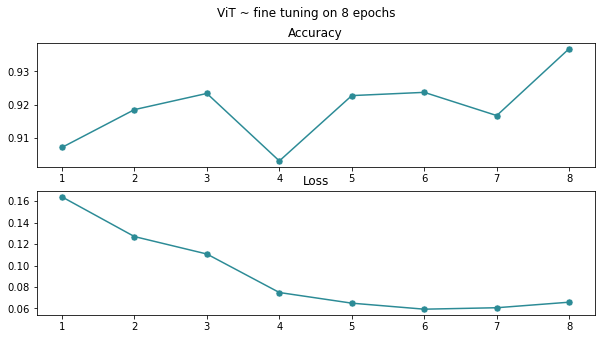

In [37]:
fig = plt.figure(figsize=(10,5))
fig.suptitle(f"ViT ~ fine tuning on {num_epochs} epochs")
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.title.set_text("Accuracy")
ax2.title.set_text("Loss")

sns.scatterplot(data=accuracy_dict, ax=ax1, color="#2C8B96", s=50)
sns.lineplot(data=accuracy_dict, ax=ax1, color="#2C8B96")
sns.scatterplot(data=loss_dict, ax=ax2, color="#2C8B96", s=50)
sns.lineplot(data=loss_dict, ax=ax2, color="#2C8B96")

plt.plot()

In [ ]:
torch.cuda.empty_cache()

##### My implementation of vanilla Transformer [пока не надо]
---

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        
        self.sqrt_v = math.sqrt(dim_out) 
        self.to_qkv = nn.Linear(dim_in, 3*dim_out)
        
    def forward(self, x):
        qkv = self.to_qkv(x)
        q, k, v = einops.rearrange(qkv, "h (k w) -> k h w", k=3)

        return torch.sigmoid(q @ k.T) @ v / self.sqrt_v

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim_in, dim_out, heads_num):
        super().__init__()
        
        self.heads_num = heads_num
        self.heads = [SelfAttention(dim_in, dim_out) for _ in range(heads_num)]
        self.epic_w = nn.Linear(heads_num * dim_out, dim_in)
        
    def forward(self, x):
        outs = [head(x) for head in self.heads]
        outs = einops.rearrange(outs, "head h w -> h (head w)", head=self.heads_num)
        x = self.epic_w(outs)
        
        return x

In [ ]:
x = torch.rand([3, 6])
x

In [ ]:
mha = MultiHeadAttention(6, 4, 2)

In [ ]:
a = mha(x)

In [ ]:
a